## About this notebook

I've created this notebook to test a simple idea: what would happen if I used [prashantkikani's architecture](https://www.kaggle.com/prashantkikani/nfl-starter-mlp-feature-engg) with [miklgr500's solution](https://www.kaggle.com/miklgr500/fork-of-neural-networks-radam-repeatkfold)? 

The result was interesting, so I decided to share it. Hope it helps you to come up with new ideas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from kaggle.competitions import nflrush
import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import keras

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})

# Overall analysis

In [3]:
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


- Let's see how PlayId is distribuited

As expected, we have 22 of each playid since we have 22 players.

Let's look at our target variable(Yards).

In [4]:
train['Yards'].describe()

count    509762.000000
mean          4.212334
std           6.436167
min         -14.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          99.000000
Name: Yards, dtype: float64

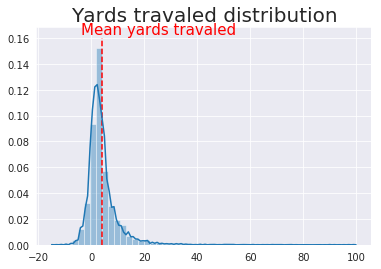

In [5]:
ax = sns.distplot(train['Yards'])
plt.vlines(train['Yards'].mean(), plt.ylim()[0], plt.ylim()[1], color='r', linestyles='--');
plt.text(train['Yards'].mean()-8, plt.ylim()[1]-0.005, "Mean yards travaled", size=15, color='r')
plt.xlabel("")
plt.title("Yards travaled distribution", size=20);

# Categorical features

In [6]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))

Let's preprocess some of those features.

## Offense formation

In [7]:
off_form = train['OffenseFormation'].unique()
train['OffenseFormation'].value_counts()

SINGLEBACK    225434
SHOTGUN       150964
I_FORM        106062
PISTOL         13420
JUMBO          11462
WILDCAT         1782
EMPTY            506
ACE               22
Name: OffenseFormation, dtype: int64

Since I don't have any knowledge about formations, I am just goig to one-hot encode this feature

In [8]:
train = pd.concat([train.drop(['OffenseFormation'], axis=1), pd.get_dummies(train['OffenseFormation'], prefix='Formation')], axis=1)
dummy_col = train.columns

## Game Clock

Game clock is supposed to be a numerical feature.

In [9]:
train['GameClock'].value_counts()

15:00:00    14476
02:00:00     5236
14:54:00     2156
14:55:00     1958
14:56:00     1276
            ...  
00:01:00      110
14:58:00       88
14:59:00       66
14:39:00       44
00:00:00       22
Name: GameClock, Length: 901, dtype: int64

Since we already have the quarter feature, we can just divide the Game Clock by 15 minutes so we can get the normalized time left in the quarter.

In [10]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

In [11]:
train['GameClock'] = train['GameClock'].apply(strtoseconds)

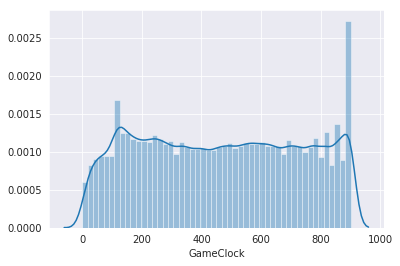

In [12]:
sns.distplot(train['GameClock'])

## Player height

We know that 1ft=12in, thus:

In [13]:
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

## Time handoff and snap and Player BirthDate

In [14]:
train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

In [15]:
train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)

In [16]:
train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

Let's use the time handoff to calculate the players age

In [17]:
seconds_in_year = 60*60*24*365.25
train['PlayerAge'] = train.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)

In [18]:
train = train.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)

## Wind Speed and Direction

We can see there are some values that are not standardized(e.g. 12mph), we are going to remove mph from all our values.

In [19]:
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)

In [20]:
#let's replace the ones that has x-y by (x+y)/2
# and also the ones with x gusts up to y
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)

In [21]:
def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1

In [22]:
train['WindSpeed'] = train['WindSpeed'].apply(str_to_float)

The wind direction won't affect our model much because we are analyzing running plays so we are just going to drop it.

In [23]:
train.drop('WindDirection', axis=1, inplace=True)

## PlayDirection

In [24]:
train['PlayDirection'] = train['PlayDirection'].apply(lambda x: (np.int32(x=='right')-0.5)*2 )

In [25]:
MID_Y = 53.3 / 2

In [26]:
FieldPosition_eq_PossessionTeam =  (train['FieldPosition'] == train['PossessionTeam'])#.value_counts()

train['start'] = 0
f = ((train['PlayDirection']==1) & FieldPosition_eq_PossessionTeam)
train['start'][f] = train['YardLine'][f]  + 10#, 

f = ((train['PlayDirection']!=1) & FieldPosition_eq_PossessionTeam)
train['start'][f] = 120 - (train['YardLine'][f]  + 10)

f = ((train['PlayDirection']==1) & (~FieldPosition_eq_PossessionTeam))
train['start'][f]  = 120 - (train['YardLine'][f]  + 10)

f = ((train['PlayDirection']!=1) & FieldPosition_eq_PossessionTeam)
train['start'][f] = train['YardLine'][f]  + 10

home, away = train['Team'].values == 'home', train['Team'].values == 'away'
indRusher = train['NflId'].values ==  train['NflIdRusher']

rad = 2 * np.pi * (90 - train[['Orientation']]) / 360
loc = np.hstack([(train['X'] - train['start']) * train['PlayDirection'], train['Y'].values - MID_Y])

v_0 = train['S'].values * np.cos(rad).values.reshape(-1)
v_1 = np.sin(rad).values.reshape(-1)

a_0 = train['A'].values * np.cos(rad).values.reshape(-1)
a_1 = np.sin(rad)

train['v_0'] = v_0
train['v_1'] = v_1
train['a_0'] = a_0
train['a_1'] = a_1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Team

In [27]:
train['Team'] = train['Team'].apply(lambda x: x.strip()=='home')

## Game Weather

In [28]:
train['GameWeather'].unique()

array(['Clear and warm', 'Sun & clouds', 'Sunny', 'Controlled Climate',
       'Mostly Sunny', 'Clear', nan, 'Indoor', 'Mostly Cloudy',
       'Mostly Coudy', 'Partly sunny', 'Partly Cloudy', 'Cloudy',
       'Sunny, highs to upper 80s', 'Indoors', 'Light Rain', 'Showers',
       'Partly cloudy', 'Partly Sunny', '30% Chance of Rain',
       'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
       'Rain', 'Cloudy, fog started developing in 2nd quarter', 'Coudy',
       'Rain likely, temps in low 40s.', 'Cold', 'N/A (Indoors)',
       'Clear skies', 'cloudy', 'Fair', 'Mostly cloudy',
       'Cloudy, chance of rain', 'Heavy lake effect snow', 'Party Cloudy',
       'Cloudy, light snow accumulating 1-3"', 'Cloudy and cold', 'Snow',
       'Hazy', 'Scattered Showers', 'Cloudy and Cool', 'N/A Indoor',
       'Rain Chance 40%', 'Clear and sunny', 'Mostly sunny',
       'Sunny and warm', 'Partly clear', 'Cloudy, 50% change of rain',
       'Clear and Sunny', '

We are going to apply the following preprocessing:
 
- Lower case
- N/A Indoor, N/A (Indoors) and Indoor => indoor Let's try to cluster those together.
- coudy and clouidy => cloudy
- party => partly
- sunny and clear => clear and sunny
- skies and mostly => ""

In [29]:
train['GameWeather'] = train['GameWeather'].str.lower()
indoor = "indoor"
train['GameWeather'] = train['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

In [30]:
train['GameWeather'].unique()

array(['clear and warm', 'sun & clouds', 'sunny', 'controlled climate',
       'clear', nan, 'indoor', 'cloudy', 'partly sunny', 'partly cloudy',
       'sunny, highs to upper 80s', 'light rain', 'showers',
       '30% chance of rain',
       'cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.',
       'rain', 'cloudy, fog started developing in 2nd quarter',
       'rain likely, temps in low 40s.', 'cold', 'fair',
       'cloudy, chance of rain', 'heavy lake effect snow',
       'cloudy, light snow accumulating 1-3"', 'cloudy and cold', 'snow',
       'hazy', 'scattered showers', 'cloudy and cool', 'rain chance 40%',
       'sunny and clear', 'sunny and warm', 'partly clear',
       'cloudy, 50% change of rain', 'sunny, windy', 'clear and cool',
       'overcast', 't: 51; h: 55; w: nw 10 mph', 'cloudy, rain',
       'rain shower', 'clear and cold', 'rainy', 'sunny and cold'],
      dtype=object)

Let's now look at the most common words we have in the weather description

In [31]:
from collections import Counter
weather_count = Counter()
for weather in train['GameWeather']:
    if pd.isna(weather):
        continue
    for word in weather.split():
        weather_count[word]+=1
        
weather_count.most_common()[:15]

[('cloudy', 193952),
 ('sunny', 127468),
 ('partly', 58256),
 ('clear', 55594),
 ('rain', 28952),
 ('indoor', 26950),
 ('controlled', 12540),
 ('climate', 12540),
 ('and', 10956),
 ('cloudy,', 4972),
 ('fair', 4972),
 ('snow', 4708),
 ('cold', 4510),
 ('of', 4026),
 ('light', 3608)]

To encode our weather we are going to do the following map:
 
- climate controlled or indoor => 3, sunny or sun => 2, clear => 1, cloudy => -1, rain => -2, snow => -3, others => 0
- partly => multiply by 0.5

I don't have any expercience with american football so I don't know if playing in a climate controlled or indoor stadium is good or not, if someone has a good idea on how to encode this it would be nice to leave it in the comments :)

In [32]:
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

In [33]:
train['GameWeather'] = train['GameWeather'].apply(map_weather)

## NflId NflIdRusher

In [34]:
train['IsRusher'] = train['NflId'] == train['NflIdRusher']

In [35]:
train.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)

# Baseline model

Let's drop the categorical features and run a simple random forest in our model

In [36]:
train = train.sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index()

In [37]:
train.drop(['GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1, inplace=True)

In [38]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append(col)
        
train = train.drop(cat_features, axis=1)

We are now going to make one big row for each play where the rusher is the last one

In [39]:
train_median = train.median()

In [40]:
train.fillna(train_median, inplace=True)

In [41]:
players_col = []
for col in train.columns:
    if train[col][:22].std()!=0:
        players_col.append(col)

In [42]:
len(players_col)

15

In [43]:
X_train = np.array(train[players_col]).reshape(-1, 15*22)

In [44]:
play_col = train.drop(players_col+['Yards'], axis=1).columns
X_play_col = np.zeros(shape=(X_train.shape[0], len(play_col)))
for i, col in enumerate(play_col):
    X_play_col[:, i] = train[col][::22]

In [45]:
X_train = np.concatenate([X_train, X_play_col], axis=1)
y_train = np.zeros(shape=(X_train.shape[0], 199))
for i,yard in enumerate(train['Yards'][::22]):
    y_train[i, yard+99:] = np.ones(shape=(1, 100-yard))

In [46]:
def crps(y_true, y_pred):
    ans = 0
    ground_t = y_true.argmax(1)
    for i, t in enumerate(ground_t):
        for n in range(-99, 100):
            h = n>=(t-99)
            
            ans+=(y_pred[i][n+99]-h)**2
            
    return ans/(199*len(y_true))

In [47]:
from keras.callbacks import EarlyStopping

In [48]:
from keras import backend as K


__all__ = ['RAdam']


class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        learning_rate: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        learning_rate = kwargs.pop('lr', learning_rate)
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = K.maximum(self.total_steps - warmup_steps, 1)
            decay_rate = (self.min_lr - lr) / decay_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr + decay_rate * K.minimum(t - warmup_steps, decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t))
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t))

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / (v_corr_t + self.epsilon), m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, learning_rate):
        self.learning_rate = learning_rate

    def get_config(self):
        config = {
            'learning_rate': float(K.get_value(self.learning_rate)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [49]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout, Activation, PReLU, Add, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import metrics

In [50]:
def give_me_model_1():
    numerical_inputs = Input(shape=(X_train.shape[1],)) 
    x = Dense(X_train.shape[1], activation=None)(numerical_inputs)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    
    logits = Dense(512,activation=None)(x)
    logits = PReLU()(logits)
    logits__ = logits
    logits = Dropout(0.5)(logits)
    
    logits = Dense(256,activation=None)(logits)
    logits = PReLU()(logits)
    logits_ = logits
    logits = Dropout(0.5)(logits)
    
    logits = Dense(256,activation=None)(logits)
    logits = PReLU()(logits)
    logits = Add()([logits, logits_,])
    logits = Dropout(0.25)(logits)
    
    out = Dense(199, activation='sigmoid')(logits)
    
    model = Model(inputs = numerical_inputs, outputs=out)
    return model

In [51]:
def train_model(x_tr, y_tr, x_vl, y_vl):
    model = give_me_model_1()
    
    er = EarlyStopping(patience=5, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    
    model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-7), loss='mse', metrics=[metrics.mae])
    model.fit(x_tr, y_tr, epochs=100, callbacks=[er], validation_data=[x_vl, y_vl])
    return model

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 

In [54]:
def make_pred(df, sample, env, models):
    df['OffenseFormation'] = df['OffenseFormation'].apply(lambda x: x if x in off_form else np.nan)
    df = pd.concat([df.drop(['OffenseFormation'], axis=1), pd.get_dummies(df['OffenseFormation'], prefix='Formation')], axis=1)
    missing_cols = set( dummy_col ) - set( test.columns )-set('Yards')
    
    for c in missing_cols:
        df[c] = 0
    
    
    df = df[dummy_col]
    df.drop(['Yards'], axis=1, inplace=True)
    df['GameClock'] = df['GameClock'].apply(strtoseconds)
    df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    seconds_in_year = 60*60*24*365.25
    df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(str_to_float)

    df['PlayDirection'] = df['PlayDirection'].apply(lambda x: (np.int32(x=='right')-0.5)*2 ).value_counts()
    df['Team'] = df['Team'].apply(lambda x: x.strip()=='home')
    indoor = "indoor"
    df['GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.lower().replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly').replace('clear and sunny', 'sunny and clear').replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(map_weather)
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    
    FieldPosition_eq_PossessionTeam =  (df['FieldPosition'] == df['PossessionTeam'])

    df['start'] = 0
    f = ((df['PlayDirection']==1) & FieldPosition_eq_PossessionTeam)
    df['start'][f] = df['YardLine'][f]  + 10#, 

    f = ((df['PlayDirection']!=1) & FieldPosition_eq_PossessionTeam)
    df['start'][f] = 120 - (df['YardLine'][f]  + 10)
    f = ((df['PlayDirection']==1) & (~FieldPosition_eq_PossessionTeam))
    df['start'][f]  = 120 - (df['YardLine'][f]  + 10)

    f = ((df['PlayDirection']!=1) & FieldPosition_eq_PossessionTeam)
    df['start'][f] = df['YardLine'][f]  + 10

    home, away = df['Team'].values == 'home', df['Team'].values == 'away'
    indRusher = df['NflId'].values ==  df['NflIdRusher']

    rad = 2 * np.pi * (90 - df[['Orientation']]) / 360
#     loc = np.hstack([(df['X'] - df['start']) * df['PlayDirection'], df['Y'].values - MID_Y])

    v_0 = df['S'].values * np.cos(rad).values.reshape(-1)
    v_1 = np.sin(rad).values.reshape(-1)
    a_0 = df['A'].values * np.cos(rad).values.reshape(-1)
    a_1 = np.sin(rad)

    df['v_0'] = v_0
    df['v_1'] = v_1
    df['a_0'] = a_0
    df['a_1'] = a_1
    
    df = df.sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index()
    df = df.drop([
        'TimeHandoff', 'TimeSnap', 'PlayerBirthDate',
        'WindDirection', 'NflId', 'NflIdRusher', 
        'GameId', 'PlayId', 'index', 'IsRusher', 'Team'
    ], axis=1)
    cat_features = []
    
    for col in df.columns:
        if df[col].dtype =='object':
            cat_features.append(col)

        
    df = df.drop(cat_features, axis=1)
    df.fillna(train_median, inplace=True)
    X = np.array(df[players_col]).reshape(-1, 15*22)
    play_col = df.drop(players_col, axis=1).columns
    X_play_col = np.zeros(shape=(X.shape[0], len(play_col)))
    for i, col in enumerate(play_col):
        X_play_col[:, i] = df[col][::22]
    X = scaler.transform(np.concatenate([X, X_play_col], axis=1))

    y_pred = np.array([model.predict(X) for model in models])
    y_pred = np.expm1(np.log1p(y_pred).mean(0))
    
    for pred in y_pred:
        prev = 0
        for i in range(len(pred)):
            if pred[i]<prev:
                pred[i]=prev
            prev=pred[i]
    env.predict(pd.DataFrame(data=y_pred,columns=sample.columns))
    return y_pred

In [55]:
# train

In [56]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=4)

In [57]:
from keras import backend as K

In [58]:
K.clear_session()

In [59]:
models = []

for fold_id, (tr_idx, vl_idx) in enumerate(rkf.split(X_train, y_train)):
    print(fold_id)
    x_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    x_vl, y_vl = X_train[vl_idx], y_train[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

0
Train on 20853 samples, validate on 2318 samples
Epoch 1/100
20853/20853 [==============================] - 10s 465us/step - loss: 0.0386 - mean_absolute_error: 0.0674 - val_loss: 0.0150 - val_mean_absolute_error: 0.0250
Epoch 2/100
20853/20853 [==============================] - 8s 405us/step - loss: 0.0149 - mean_absolute_error: 0.0275 - val_loss: 0.0143 - val_mean_absolute_error: 0.0301
Epoch 3/100
20853/20853 [==============================] - 8s 406us/step - loss: 0.0140 - mean_absolute_error: 0.0270 - val_loss: 0.0143 - val_mean_absolute_error: 0.0290
Epoch 4/100
20853/20853 [==============================] - 8s 404us/step - loss: 0.0136 - mean_absolute_error: 0.0260 - val_loss: 0.0142 - val_mean_absolute_error: 0.0274
Epoch 5/100
20853/20853 [==============================] - 8s 404us/step - loss: 0.0133 - mean_absolute_error: 0.0252 - val_loss: 0.0142 - val_mean_absolute_error: 0.0271
Epoch 6/100
20853/20853 [==============================] - 8s 404us/step - loss: 0.0128 - mea

In [60]:
env = nflrush.make_env()

In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
len(models)

40

In [63]:
for test, sample in tqdm.tqdm(env.iter_test()):
    make_pred(test, sample, env, models)

3438it [30:25,  1.88it/s]


In [64]:
env.write_submission_file()

Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.


# End

If you reached this far please comment and upvote this kernel, feel free to make improvements on the kernel and please share if you found anything useful!